In [1]:
! pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -c conda-forge rdkit
! pip install chembl-webresource-client

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        Supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Getting  conda-forge linux-64
Getting  conda-forge noarch
Getting  pkgs/main linux-64
Getting  pkgs/ma

### Connect to ChEMBL database

First, the ChEMBL webresource client as well as other Python libraries are imported.

In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [4]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [5]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

# D(2) dopamine receptor DRD2 Homo sapiens (Human)

In [6]:
uniprot_id = "P14416"

#### Fetch target data from ChEMBL

In [7]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [8]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Dopamine D2 receptor,CHEMBL217,SINGLE PROTEIN
1,Homo sapiens,Dopamine D2 receptor,CHEMBL217,SINGLE PROTEIN
2,Homo sapiens,Dopamine receptors; D2 & D3,CHEMBL2095169,SELECTIVITY GROUP
3,Homo sapiens,Dopamine receptors; D2 & D4,CHEMBL2095396,SELECTIVITY GROUP
4,Homo sapiens,Dopamine receptor,CHEMBL2096905,PROTEIN FAMILY
5,Homo sapiens,Dopamine D2 receptor and serotonin 1a receptor,CHEMBL2111460,SELECTIVITY GROUP
6,Homo sapiens,Dopamine D2 receptor and serotonin 2a receptor,CHEMBL2111468,SELECTIVITY GROUP
7,Homo sapiens,Dopamine D1 and D2 receptor,CHEMBL2111341,SELECTIVITY GROUP
8,Homo sapiens,D2-like dopamine receptor,CHEMBL2331075,PROTEIN FAMILY
9,Homo sapiens,Dopamine receptor D2L/neurotensin receptor NTS1,CHEMBL3038478,PROTEIN COMPLEX


In [9]:
target = targets.iloc[0]
target

organism                    Homo sapiens
pref_name           Dopamine D2 receptor
target_chembl_id               CHEMBL217
target_type               SINGLE PROTEIN
Name: 0, dtype: object

Save selected ChEMBL ID.

In [10]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL217


### Get bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Fetch bioactivity data for the target from ChEMBL

In this step, we fetch the bioactivity data and filter it to only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [11]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

In [12]:
print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 331, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [13]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32111,
 'assay_chembl_id': 'CHEMBL671073',
 'assay_description': 'Binding affinity to cloned human Dopamine receptor D2 expressed in A9L cells by [3H]spiperone displacement.',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL303519',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '9800.0',
 'target_chembl_id': 'CHEMBL217',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'nM',
 'value': '9800.0'}

#### Download bioactivity data from ChEMBL

In [14]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)

In [15]:
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (332, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32111,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL303519,=,nM,9800.0,CHEMBL217,Homo sapiens,IC50,nM,9800.0
1,32111,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL303519,=,nM,9800.0,CHEMBL217,Homo sapiens,IC50,nM,9800.0
2,33282,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL292943,=,nM,50.0,CHEMBL217,Homo sapiens,IC50,nM,50.0
3,38258,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL61682,=,nM,25.0,CHEMBL217,Homo sapiens,IC50,nM,25.0
4,39387,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL64487,=,nM,360.0,CHEMBL217,Homo sapiens,IC50,nM,360.0


Note that the first two rows describe the same bioactivity entry; we will remove such artifacts later during the deduplication step. Note also that we have columns for `standard_units`/`units` and `standard_values`/`values`; in the following, we will use the standardized columns (standardization by ChEMBL), and thus, we drop the other two columns.

If we used the `units` and `values` columns, we would need to convert all values with many different units to nM:

In [16]:
bioactivities_df["units"].unique()

array(['nM', 'uM', 'M', "10'-9M", "10'-4M"], dtype=object)

In [17]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32111,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL303519,=,nM,9800.0,CHEMBL217,Homo sapiens,IC50
1,32111,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL303519,=,nM,9800.0,CHEMBL217,Homo sapiens,IC50
2,33282,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL292943,=,nM,50.0,CHEMBL217,Homo sapiens,IC50
3,38258,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL61682,=,nM,25.0,CHEMBL217,Homo sapiens,IC50
4,39387,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL64487,=,nM,360.0,CHEMBL217,Homo sapiens,IC50


#### Preprocess and filter bioactivity data

1. Convert `standard_value`'s datatype from `object` to `float`
2. Delete entries with missing values
3. Keep only entries with `standard_unit == nM`
4. Delete duplicate molecules
5. Reset `DataFrame` index
6. Rename columns

**1. Convert datatype of "standard_value" from "object" to "float"**

The field `standard_value` holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [18]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [19]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values**

Use the parameter `inplace=True` to drop values in the current `DataFrame` directly.

In [20]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (332, 11)


**3. Keep only entries with "standard_unit == nM"** 

We only want to keep bioactivity entries in `nM`, thus we remove all entries with other units.

In [21]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [22]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [23]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (332, 11)


**4. Delete duplicate molecules**

Sometimes the same molecule (`molecule_chembl_id`) has been tested more than once, in this case, we only keep the first one.

Note other choices could be to keep the one with the best value or a mean value of all assay results for the respective compound.

In [24]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (286, 11)


**5. Reset "DataFrame" index**

Since we deleted some rows, but we want to iterate over the index later, we reset the index to be continuous.

In [25]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32111,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL303519,=,nM,9800.0,CHEMBL217,Homo sapiens,IC50
1,33282,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL292943,=,nM,50.0,CHEMBL217,Homo sapiens,IC50
2,38258,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL61682,=,nM,25.0,CHEMBL217,Homo sapiens,IC50
3,39387,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL64487,=,nM,360.0,CHEMBL217,Homo sapiens,IC50
4,39391,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL64597,=,nM,300.0,CHEMBL217,Homo sapiens,IC50


**6. Rename columns**

In [26]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32111,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL303519,=,nM,9800.0,CHEMBL217,Homo sapiens,IC50
1,33282,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL292943,=,nM,50.0,CHEMBL217,Homo sapiens,IC50
2,38258,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL61682,=,nM,25.0,CHEMBL217,Homo sapiens,IC50
3,39387,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL64487,=,nM,360.0,CHEMBL217,Homo sapiens,IC50
4,39391,CHEMBL671073,Binding affinity to cloned human Dopamine rece...,B,CHEMBL64597,=,nM,300.0,CHEMBL217,Homo sapiens,IC50


In [27]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (286, 11)


### Get compound data

In [28]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

#### Download compound data from ChEMBL

Again, we want to export the `QuerySet` object into a `pandas.DataFrame`. Given the data volume, **this can take some time.** For that reason, we will first obtain the list of records through `tqdm`, so we get a nice progress bar and some ETAs. We can then pass the list of compounds to the DataFrame.

In [29]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/286 [00:00<?, ?it/s]

In [30]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (286, 2)


In [31]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL11,{'canonical_smiles': 'CN(C)CCCN1c2ccccc2CCc2cc...
1,CHEMBL411,{'canonical_smiles': 'CC/C(=C(/CC)c1ccc(O)cc1)...
2,CHEMBL415,{'canonical_smiles': 'CN(C)CCCN1c2ccccc2CCc2cc...
3,CHEMBL26,{'canonical_smiles': 'CCN1CCCC1CNC(=O)c1cc(S(N...
4,CHEMBL442,{'canonical_smiles': 'CN1C[C@H](C(=O)N[C@]2(C)...


#### Preprocess and filter compound data

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [32]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (286, 2)


**2. Delete duplicate molecules**

In [33]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (286, 2)


**3. Get molecules with canonical SMILES**

So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [34]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [35]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (286, 2)


Sanity check: Remove all molecules without a canonical SMILES string.

In [36]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (286, 2)


### Output (bioactivity-compound) data
**Summary of compound and bioactivity data**

In [37]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 286


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [38]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 286


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds' ChEMBL IDs (`molecule_chembl_id`), keeping the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [39]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 286 entries.


In [40]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [41]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL303519,9800.0,nM,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1
1,CHEMBL292943,50.0,nM,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1
2,CHEMBL61682,25.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1
3,CHEMBL64487,360.0,nM,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1
4,CHEMBL64597,300.0,nM,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1
5,CHEMBL291824,70.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccc(F)cc4)CC3)c2)cc1
6,CHEMBL59942,49.0,nM,Fc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1
7,CHEMBL61657,60.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccn4)CC3)c2)cc1
8,CHEMBL302183,120.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ncccn4)CC3)c2)cc1
9,CHEMBL304692,2300.0,nM,c1cnc(N2CCN(Cc3cccc4c3-c3ccccc3C4)CC2)nc1


#### Add pIC50 values

As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [42]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [43]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [44]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL303519,9800.0,nM,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774
1,CHEMBL292943,50.0,nM,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030
2,CHEMBL61682,25.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060
3,CHEMBL64487,360.0,nM,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697
4,CHEMBL64597,300.0,nM,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879


In [45]:
output_df.to_csv('D2_targets.csv', index=False)

#### Draw compound data

Let's have a look at our collected data set.

First, we plot the pIC50 value distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14e612b590>]],
      dtype=object)

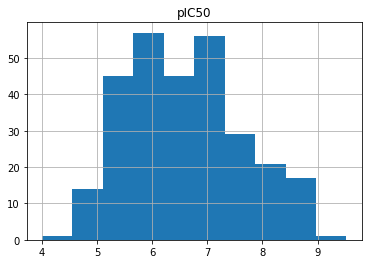

In [46]:
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our `DataFrame` and look at the structures of the molecules with the highest pIC50 values. 

In [47]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [48]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

Show the three most active molecules, i.e. molecules with the highest pIC50 values.

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL567,0.300,nM,9.522879,
1,CHEMBL3885419,1.100,nM,8.958607,
2,CHEMBL8514,1.100,nM,8.958607,
3,CHEMBL267930,1.270,nM,8.896196,
4,CHEMBL1255837,1.474,nM,8.831503,

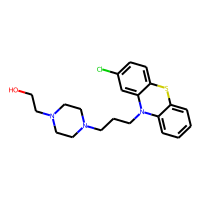
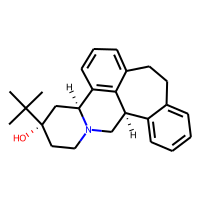
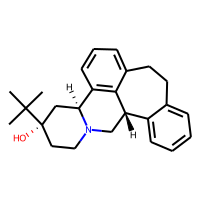
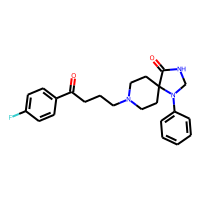
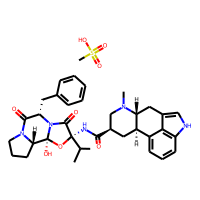

In [49]:
output_df.drop("smiles", axis=1).head(5)

In [50]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [51]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

### Apply Ro5 to the dataset

The `calculate_ro5_properties` function can be applied to the dataset for Ro5-compliant compounds.

In [52]:
molecules = pd.read_csv("D2_targets.csv")
print(molecules.shape)
molecules.head()

(286, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL303519,9800.0,nM,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774
1,CHEMBL292943,50.0,nM,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030
2,CHEMBL61682,25.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060
3,CHEMBL64487,360.0,nM,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697
4,CHEMBL64597,300.0,nM,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879


In [53]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,342.184447,4,0,3.3700,True
1,360.195011,5,0,3.4744,True
2,365.170354,3,0,4.3490,True
3,360.195011,5,0,3.4744,True
4,336.140868,5,0,3.5273,True


In [54]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL303519,9800.0,nM,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774,342.184447,4,0,3.3700,True
1,CHEMBL292943,50.0,nM,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030,360.195011,5,0,3.4744,True
2,CHEMBL61682,25.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060,365.170354,3,0,4.3490,True
3,CHEMBL64487,360.0,nM,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697,360.195011,5,0,3.4744,True
4,CHEMBL64597,300.0,nM,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879,336.140868,5,0,3.5273,True


In [55]:
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 286
# compounds in filtered data set: 252
# compounds not compliant with the Ro5: 34


In [57]:
# Save filtered data
molecules_ro5_fulfilled.to_csv("D2_compounds_lipinski.csv")
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL303519,9800.0,nM,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774,342.184447,4,0,3.3700,True
1,CHEMBL292943,50.0,nM,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030,360.195011,5,0,3.4744,True
2,CHEMBL61682,25.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060,365.170354,3,0,4.3490,True
3,CHEMBL64487,360.0,nM,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697,360.195011,5,0,3.4744,True
4,CHEMBL64597,300.0,nM,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879,336.140868,5,0,3.5273,True


### Visualize Ro5 properties (radar plot)

In [58]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

In [59]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,409.377274,80.282062
n_hba,4.246032,1.689841
n_hbd,0.932540,0.997713
logp,3.937496,1.160086


In [60]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,803.084347,235.368035
n_hba,8.588235,4.098171
n_hbd,2.794118,1.591253
logp,7.394946,2.283829


#### Define helper functions to prepare data for radar plotting

__Prepare y values__: 
The properties used for the Ro5 criteria are of different magnitudes. 
The MWT has a __threshold of 500__, whereas the number of HBAs and HBDs and the LogP have __thresholds of only 10, 5, and 5__, respectively. In order to visualize these different scales most simplistically, we will scale all property values to a __scaled threshold of 5__:

`scaled property value` = `property value` / `property threshold` * `scaled property threshold`

- scaled MWT = MWT / 500 * 5 = MWT / 100
- scaled HBA = HBA / 10 * 5 = HBA / 2
- scaled HBD = HBD / 5 * 5 = HBD
- scaled LogP = LogP / 5 * 5 = LogP

This results in a downscaling of the MWT by 100, HBA by 2, while HBD and LogP stay unchanged.

The following helper function performs such a scaling and will be used later during radar plotting.

In [61]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

__Prepare x values:__
The following helper function returns the __angles of the physicochemical property axes for the radar chart__. For example, if we want to generate a radar plot for 4 properties, we want to set the axes at 0°, 90°, 180°, and 270°. The helper function returns such angles as radians.

In [62]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [63]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 5, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In the following, we want to plot the radar chart for our two datasets:
1. Compounds that fulfill the Ro5
2. Compounds that violate the Ro5

Define input parameters that should stay the same for both radar charts:

In [64]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

1. We plot the radarplot for the dataset of compounds that __fulfill the Ro5__.

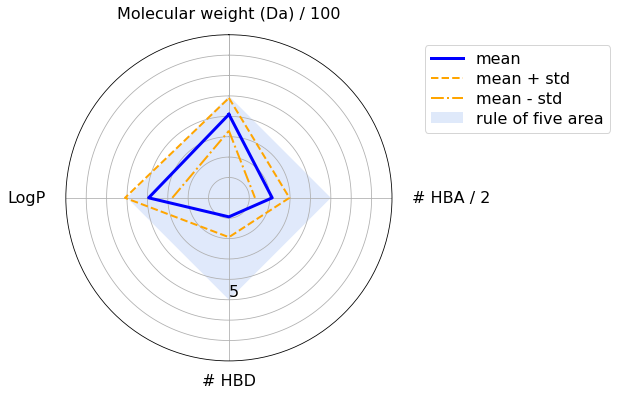

In [65]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

2. We plot the radarplot for the dataset of compounds that __violate the Ro5__.

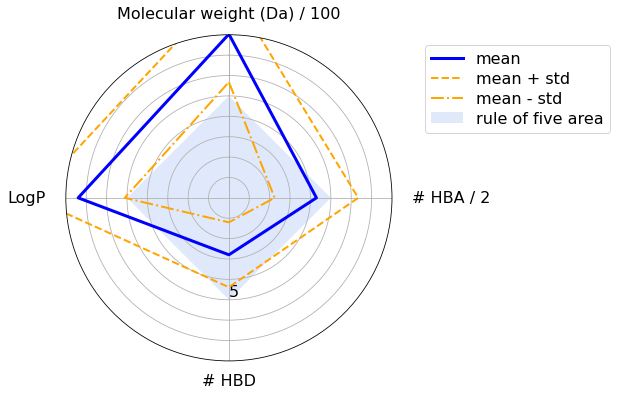

In [66]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

In [67]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [69]:
data = pd.read_csv("D2_compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", data.shape)
data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
data.head()

Dataframe shape: (252, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL303519,9800.0,nM,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774,True
1,CHEMBL292943,50.0,nM,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030,True
2,CHEMBL61682,25.0,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060,True
3,CHEMBL64487,360.0,nM,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697,True
4,CHEMBL64597,300.0,nM,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879,True


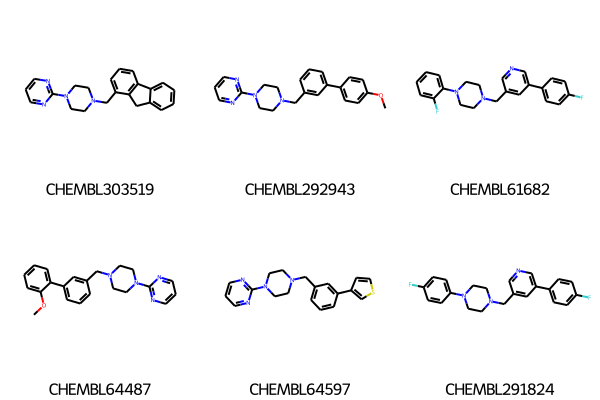

In [70]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(data, smilesCol="smiles")
# Draw first 6 molecules
Chem.Draw.MolsToGridImage(
    list(data.head(6).ROMol),
    legends=list(data.head(6).molecule_chembl_id),
)

### Filter for PAINS

The PAINS filter is already implemented in RDKit ([documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html)). Such pre-defined filters can be applied via the `FilterCatalog` class. Let's learn how it can be used.

In [71]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [72]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
data = data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/252 [00:00<?, ?it/s]

In [73]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(data)}")

Number of compounds with PAINS: 13
Number of compounds without PAINS: 239


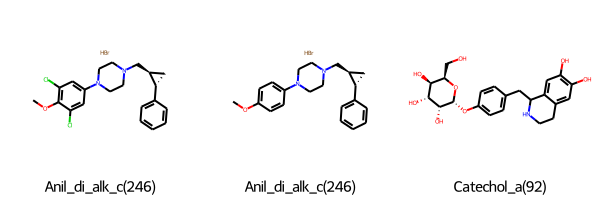

In [74]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

### Filter and highlight unwanted substructures

Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches manually. 
Here, we use the list provided in the supporting information from Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 535-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).

In [75]:
substructures = pd.read_csv("unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


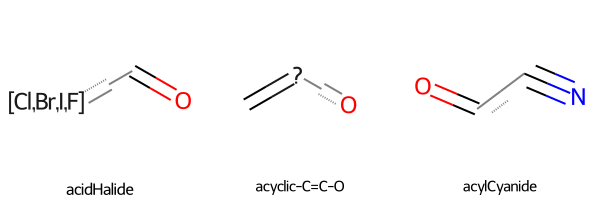

In [76]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

Search our filtered dataframe for matches with these unwanted substructures.

In [77]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = data.loc[clean]

  0%|          | 0/239 [00:00<?, ?it/s]

In [78]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(data)}")

Number of found unwanted substructure: 98
Number of compounds without unwanted substructure: 239


In [80]:
data = data.drop("ROMol", axis=1)
data

,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL303519,9800.00,nM,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774,True
1,CHEMBL292943,50.00,nM,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030,True
2,CHEMBL61682,25.00,nM,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060,True
3,CHEMBL64487,360.00,nM,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697,True
4,CHEMBL64597,300.00,nM,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879,True
...,...,...,...,...,...,...
281,CHEMBL4442011,40.77,nM,CCc1ccc2c3c1CCN(C)[C@H]3Cc1ccc(OC)c(OC)c1-2,7.389659,True
282,CHEMBL4589737,3629.00,nM,COc1ccc2c(c1OC)-c1ccc(C)c3c1[C@@H](C2)N(C)CC3,5.440213,True
283,CHEMBL8809,1.83,nM,CCN1CCC[C@H]1CNC(=O)c1c(O)c(Cl)cc(Cl)c1OC,8.737549,True
284,CHEMBL4451797,71.00,nM,CN(C)C(=O)N[C@H]1CC[C@H](CCN2CCc3cccc(Cl)c3C2)CC1,7.148742,True


In [81]:
data.to_csv('D2_pains_unwanted_filt.csv', index=False)

### Highlight substructures

Let's have a look at the first 3 identified unwanted substructures. Since we have access to the underlying SMARTS patterns we can highlight the substructures within the RDKit molecules.

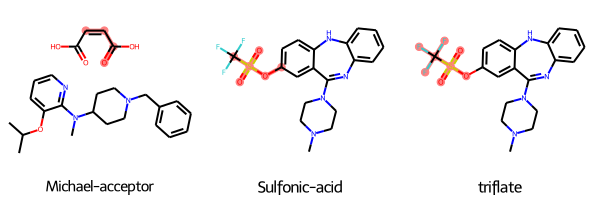

In [82]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

### Substructure statistics

Finally, we want to find the most frequent substructure found in our data set. The Pandas `DataFrame` provides convenient methods to group containing data and to retrieve group sizes.

In [83]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
Aliphatic-long-chain           39
Michael-acceptor                9
isolate-alkene                  6
aniline                         5
triple-bond                     5
Sulfonic-acid                   5
triflate                        4
charged-oxygen/sulfur-atoms     3
stilbene                        3
cumarine                        2
dtype: int64

# Filtering active compounds

In [84]:
import dataclasses
# Keep only the columns we want
chembl_df = data[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879


#### Data labeling
We need to classify each compound as active or inactive. Therefore, we use the pIC50 value.

* pIC50 = -log10(IC50) 
* IC50 describes the amount of substance needed to inhibit, _in vitro_, a process by 50% .
* A common cut-off value to discretize pIC50 data is 6.3, which we will use for our experiment (refer to [<i>J. Med. Chem.</i> (2017), <b>60</b>, 474-485](https://doi.org/10.1021/acs.jmedchem.6b01611) and the corresponding
[notebook](https://github.com/Team-SKI/Publications/blob/master/Profiling_prediction_of_kinase_inhibitors/Build_ABL1_model.ipynb))
* Note that there are several other suggestions for an activity cut-off ranging from an pIC50 value of 5 to 7 in the literature or even to define an exclusion range when not to take data points. 

In [85]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.0, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.0].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 177
Number of inactive compounds: 62


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [86]:
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.008774,0.0
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.301030,1.0
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,7.602060,1.0
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,6.443697,1.0
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,6.522879,1.0


In [90]:
chembl_df[chembl_df.active == 1].to_csv('active_filtered.csv')

In [ ]:
chembl_df[chembl_df.active == 0].to_csv('unactive_filtered.csv')